In [9]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [10]:
train_dir = "/content/drive/MyDrive/AI and Machine Learning/week 5/FruitinAmazon (1)/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/AI and Machine Learning/week 5/FruitinAmazon (1)/FruitinAmazon/test"

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['tucuma', 'graviola', 'acai', 'cupuacu', 'guarana', 'pupunha']


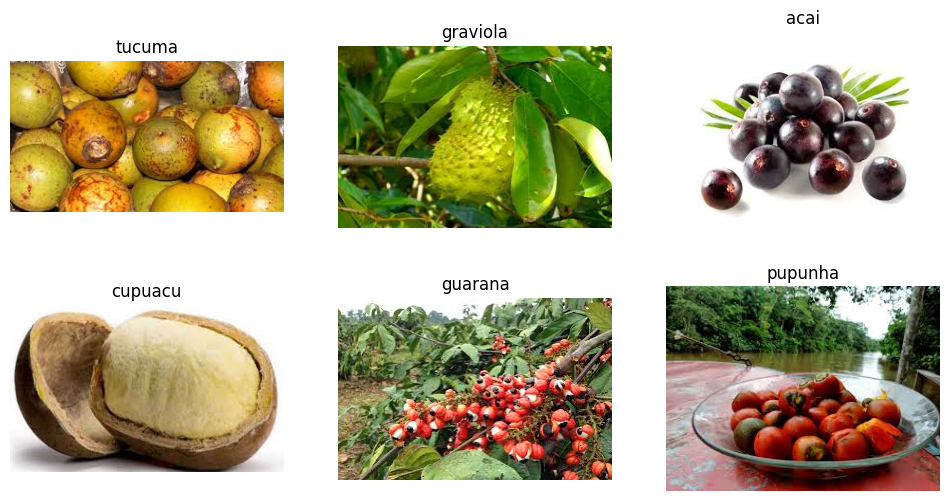

In [13]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [8]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


In [14]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [17]:
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [18]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2), strides=2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.1296 - loss: 1.9588

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step - accuracy: 0.1319 - loss: 1.9782 - val_accuracy: 0.6111 - val_loss: 1.4801
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 806ms/step - accuracy: 0.2018 - loss: 1.7865 - val_accuracy: 0.0556 - val_loss: 1.7686
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 422ms/step - accuracy: 0.2079 - loss: 1.7049 - val_accuracy: 0.2778 - val_loss: 1.6932
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.2593 - loss: 1.6036

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - accuracy: 0.2639 - loss: 1.5981 - val_accuracy: 0.7222 - val_loss: 1.4560
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step - accuracy: 0.3546 - loss: 1.3774 - val_accuracy: 0.7222 - val_loss: 1.1560
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 503ms/step - accuracy: 0.4362 - loss: 1.2074 - val_accuracy: 0.6111 - val_loss: 1.4047
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 695ms/step - accuracy: 0.7431 - loss: 0.9804 - val_accuracy: 0.7222 - val_loss: 0.9370
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.8542 - loss: 0.7627 - val_accuracy: 0.6667 - val_loss: 0.9236
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8663 - loss: 0.5149

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.8581 - loss: 0.5279 - val_accuracy: 0.9444 - val_loss: 0.5274
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.9271 - loss: 0.3762 - val_accuracy: 0.5556 - val_loss: 0.8986
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.8828 - loss: 0.3132 - val_accuracy: 0.7778 - val_loss: 1.0553
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 1.0000 - loss: 0.2095 - val_accuracy: 0.8889 - val_loss: 0.3541
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 774ms/step - accuracy: 0.9783 - loss: 0.1189 - val_accuracy: 0.8333 - val_loss: 0.4699
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 422ms/step - accuracy: 1.0000 - loss: 0.0737 - val_accuracy: 0.8333 - val_loss: 0.7077
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 425ms/step - accuracy: 0.9891 - loss: 0.0582 - val_accuracy: 0.8333 - val_loss: 0.4581
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 437ms/step - accuracy: 1.0000 - loss: 0.0275 - val_accuracy: 0.8889 - val_lo

In [21]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6667 - loss: 1.0094
Test Accuracy: 66.67%


In [22]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [23]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = loaded_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
              precision    recall  f1-score   support

      tucuma       0.56      1.00      0.71         5
    graviola       0.60      0.60      0.60         5
        acai       0.67      0.80      0.73         5
     cupuacu       0.75      0.60      0.67         5
     guarana       1.00      0.60      0.75         5
     pupunha       0.67      0.40      0.50         5

    accuracy                           0.67        30
   macro avg       0.71      0.67      0.66        30
weighted avg       0.71      0.67      0.66        30



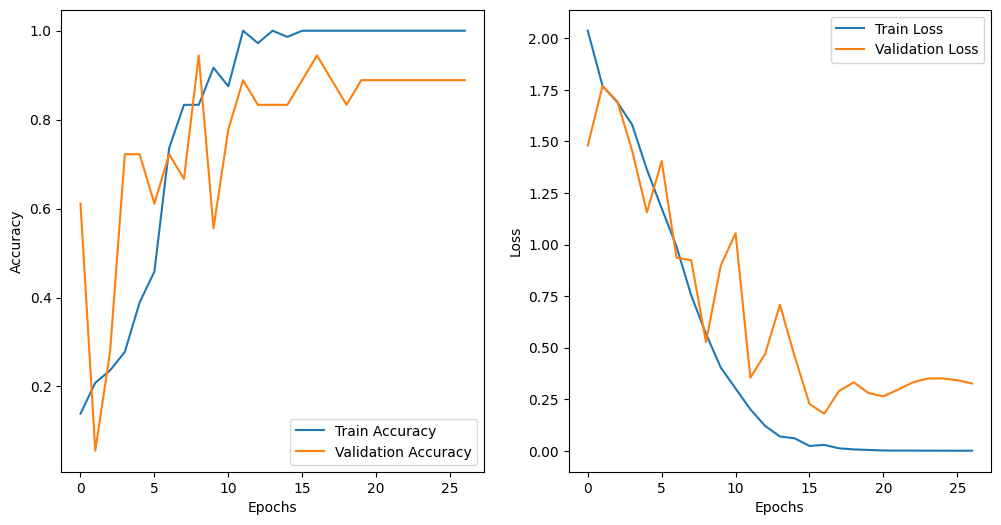

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()